In [1]:
!pip install -q torchinfo


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import os
from torchvision.datasets.mnist import MNIST

from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch
from torch import nn, optim
import torchvision
from torchvision.utils import make_grid
from torchinfo import summary

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

False cpu


In [4]:
seed = 130
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.25MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


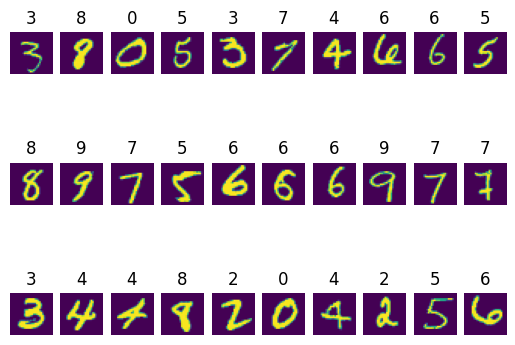

In [5]:
base_dir = "dataset"

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])
mnist = DataLoader(MNIST(base_dir, train=True, download=True, transform=transform),
                   batch_size=30, shuffle=True)

for images, labels in mnist:
  for i in range(len(images)):
    plt.subplot(3, 10, i+1)
    plt.title(labels[i].item())
    plt.imshow(images[i].squeeze())
    plt.axis("off")
  break

In [6]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.label_emb = nn.Embedding(10, 10)
    self.model = nn.Sequential(
      nn.Linear(794, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x, labels):
    x = nn.Flatten()(x)
    c = self.label_emb(labels)
    x = torch.cat([x, c], dim=1)
    out = self.model(x)
    return out.squeeze()

In [7]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.label_emb = nn.Embedding(10, 10)
    self.model = nn.Sequential(
      nn.Linear(110, 256),
      nn.LeakyReLU(0.2),
      nn.Linear(256, 512),
      nn.LeakyReLU(0.2),
      nn.Linear(512, 1024),
      nn.LeakyReLU(0.2),
      nn.Linear(1024, 784),
      nn.Tanh()
    )

  def forward(self, z, labels):
    z = nn.Flatten()(z)
    c = self.label_emb(labels)
    x = torch.cat([z, c], 1)
    out = self.model(x)
    return out.reshape(-1, 28, 28)

In [8]:
dummy_z = torch.randn(1, 100)
dummy_c = torch.randint(0, 10, (1,))
summary(Generator(), input_data=(dummy_z, dummy_c))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 28, 28]               --
├─Embedding: 1-1                         [1, 10]                   100
├─Sequential: 1-2                        [1, 784]                  --
│    └─Linear: 2-1                       [1, 256]                  28,416
│    └─LeakyReLU: 2-2                    [1, 256]                  --
│    └─Linear: 2-3                       [1, 512]                  131,584
│    └─LeakyReLU: 2-4                    [1, 512]                  --
│    └─Linear: 2-5                       [1, 1024]                 525,312
│    └─LeakyReLU: 2-6                    [1, 1024]                 --
│    └─Linear: 2-7                       [1, 784]                  803,600
│    └─Tanh: 2-8                         [1, 784]                  --
Total params: 1,489,012
Trainable params: 1,489,012
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.49
Input size (MB): 0.

In [9]:
dummy_x = torch.randn(1, 28, 28)
dummy_c = torch.randint(0, 10, (1,))
summary(Discriminator(), input_data=(dummy_x, dummy_c))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Embedding: 1-1                         [1, 10]                   100
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 1024]                 814,080
│    └─ReLU: 2-2                         [1, 1024]                 --
│    └─Linear: 2-3                       [1, 512]                  524,800
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 256]                  131,328
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─Linear: 2-7                       [1, 1]                    257
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 1,470,565
Trainable params: 1,470,565
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.47
Input size (MB): 0.00


In [10]:
def generator_train_step(batch_size, discriminator, generator,
                         g_optimizer, criterion, device):
  z = torch.randn(batch_size, 100).to(device)
  fake_labels = torch.randint(0, 10, (batch_size,)).to(device)

  g_optimizer.zero_grad()

  fake_images = generator(z, fake_labels)
  validity = discriminator(fake_images, fake_labels)

  g_loss = criterion(validity, torch.ones(batch_size).to(device))
  g_loss.backward()
  g_optimizer.step()

  return g_loss.item()

In [11]:
def discriminator_train_step(batch_size, discriminator, generator,
                             d_optimizer, criterion,
                             images, labels, device):
  d_optimizer.zero_grad()

  # train with real images
  real_validity = discriminator(images.to(device), labels.to(device))
  real_loss = criterion(real_validity, torch.ones(batch_size).to(device))

  # train with fake images
  z = torch.randn(batch_size, 100).to(device)
  fake_labels = torch.randint(0, 10, (batch_size,)).to(device)

  fake_images = generator(z, fake_labels)
  fake_validity = discriminator(fake_images, fake_labels)
  fake_loss = criterion(fake_validity, torch.zeros(batch_size).to(device))

  d_loss = real_loss + fake_loss
  d_loss.backward()
  d_optimizer.step()

  return d_loss.item()

In [12]:
def train(generator, discriminator, dataloader, criterion,
          g_optimizer, d_optimizer, epoch, device, n_critic=3):

  generator.train()
  discriminator.train()

  running_g_loss = 0
  running_d_loss = 0

  with tqdm(dataloader) as pbar:
    for i, (images, labels) in enumerate(pbar):

      batch_size = len(images)

      # train discriminator in n_critic
      d_loss = 0
      for _ in range(n_critic):
        d_loss += discriminator_train_step(batch_size, discriminator,
                                           generator, d_optimizer, criterion,
                                           images, labels, device)
      d_loss /= n_critic

      # train generator
      g_loss = generator_train_step(batch_size, discriminator, generator,
                                    g_optimizer, criterion, device)

      running_d_loss += d_loss
      running_g_loss += g_loss
      pbar.set_postfix(d_loss=d_loss, g_loss=g_loss)

  return running_d_loss/len(dataloader), running_g_loss/len(dataloader)

In [13]:
def validation(generator, epoch, device):
  generator.eval()

  z = torch.randn(10, 100).to(device)
  labels = torch.arange(0, 10).to(device)
  images = generator(z, labels).unsqueeze(1)

  grid = make_grid(images, nrow=10, normalize=True)

  fig, ax = plt.subplots(figsize=(10, 1))
  ax.imshow(grid.permute(1, 2, 0).cpu(), cmap='binary')
  ax.axis('off')
  plt.show()

Epoch: 0


100%|██████████| 938/938 [03:03<00:00,  5.12it/s, d_loss=0.00246, g_loss=8.75] 


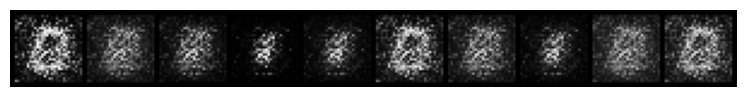

Epoch: 1


100%|██████████| 938/938 [02:59<00:00,  5.21it/s, d_loss=0.00747, g_loss=6.51] 


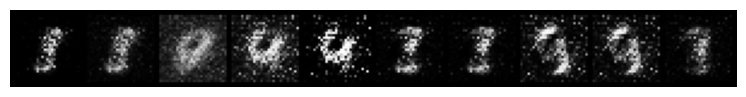

Epoch: 2


100%|██████████| 938/938 [03:02<00:00,  5.15it/s, d_loss=0.279, g_loss=20.2]   


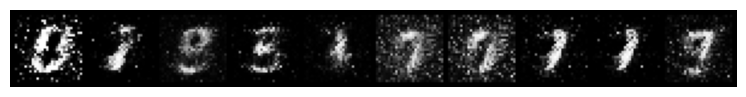

Epoch: 3


100%|██████████| 938/938 [03:04<00:00,  5.08it/s, d_loss=0.0498, g_loss=8.72]  


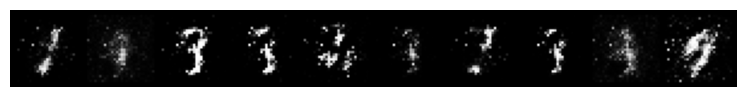

Epoch: 4


100%|██████████| 938/938 [03:07<00:00,  5.01it/s, d_loss=0.0321, g_loss=8.13]  


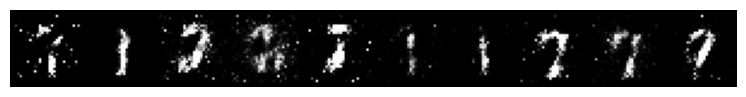

Epoch: 5


100%|██████████| 938/938 [03:07<00:00,  4.99it/s, d_loss=0.0675, g_loss=7.42] 


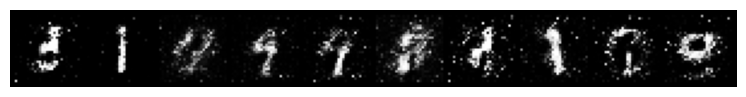

Epoch: 6


100%|██████████| 938/938 [03:20<00:00,  4.68it/s, d_loss=0.0919, g_loss=7.2]  


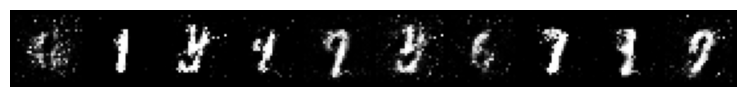

Epoch: 7


100%|██████████| 938/938 [03:14<00:00,  4.82it/s, d_loss=0.0786, g_loss=6]   


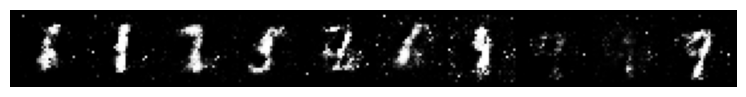

Epoch: 8


100%|██████████| 938/938 [03:12<00:00,  4.88it/s, d_loss=0.15, g_loss=4.87]   


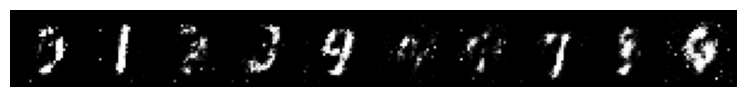

Epoch: 9


100%|██████████| 938/938 [03:10<00:00,  4.93it/s, d_loss=0.201, g_loss=4]    


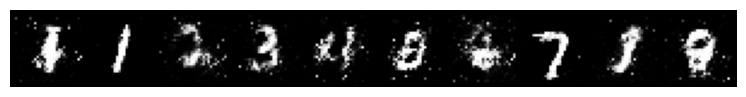

Epoch: 10


100%|██████████| 938/938 [03:19<00:00,  4.69it/s, d_loss=0.201, g_loss=4.41] 


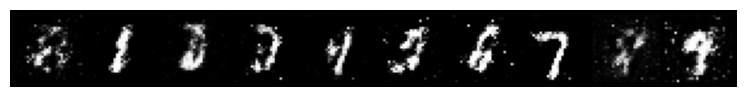

Epoch: 11


100%|██████████| 938/938 [03:55<00:00,  3.98it/s, d_loss=0.469, g_loss=3.1]  


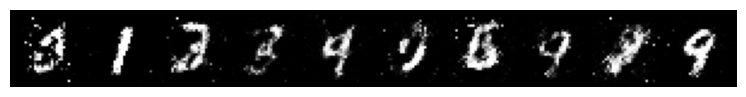

Epoch: 12


100%|██████████| 938/938 [04:15<00:00,  3.68it/s, d_loss=0.287, g_loss=4.25] 


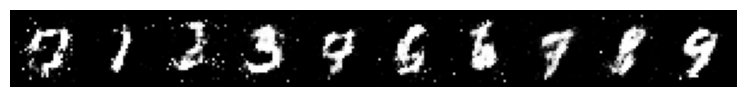

Epoch: 13


100%|██████████| 938/938 [04:10<00:00,  3.74it/s, d_loss=0.423, g_loss=3.51]


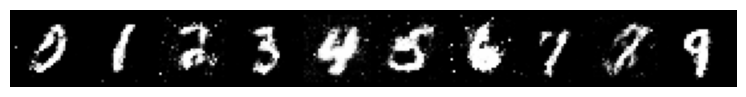

Epoch: 14


100%|██████████| 938/938 [04:00<00:00,  3.90it/s, d_loss=0.213, g_loss=3.72]


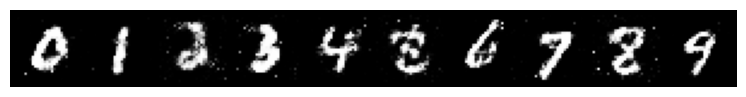

Epoch: 15


100%|██████████| 938/938 [03:59<00:00,  3.92it/s, d_loss=0.492, g_loss=2.71]


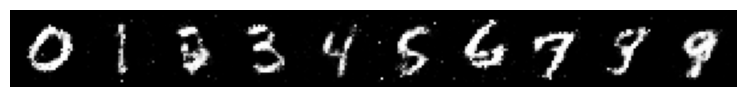

Epoch: 16


100%|██████████| 938/938 [04:00<00:00,  3.90it/s, d_loss=0.513, g_loss=3.19]


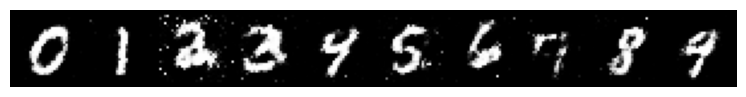

Epoch: 17


100%|██████████| 938/938 [03:57<00:00,  3.95it/s, d_loss=0.606, g_loss=2.31]


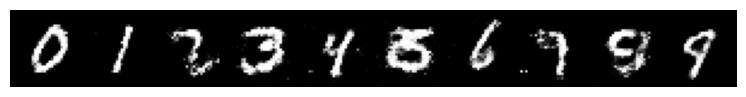

Epoch: 18


100%|██████████| 938/938 [03:02<00:00,  5.15it/s, d_loss=0.544, g_loss=3.62]


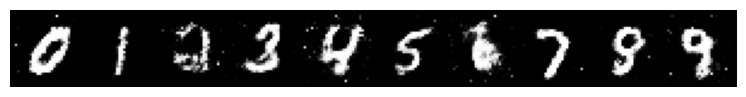

Epoch: 19


100%|██████████| 938/938 [03:16<00:00,  4.76it/s, d_loss=0.491, g_loss=2.76]


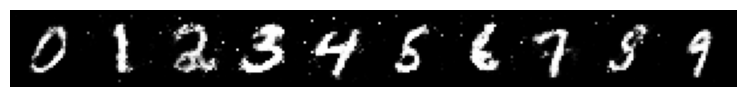

Epoch: 20


100%|██████████| 938/938 [03:16<00:00,  4.77it/s, d_loss=0.783, g_loss=2.7] 


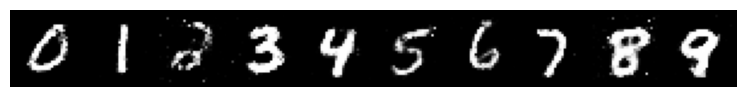

Epoch: 21


100%|██████████| 938/938 [03:18<00:00,  4.73it/s, d_loss=0.577, g_loss=2.37]


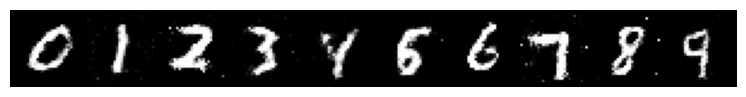

Epoch: 22


100%|██████████| 938/938 [03:16<00:00,  4.77it/s, d_loss=0.426, g_loss=2.98]


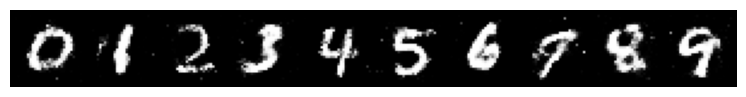

Epoch: 23


100%|██████████| 938/938 [03:24<00:00,  4.60it/s, d_loss=0.388, g_loss=2.82]


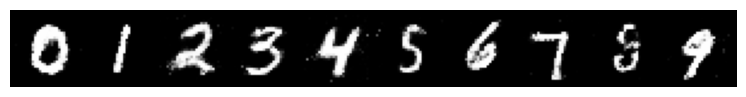

Epoch: 24


100%|██████████| 938/938 [03:18<00:00,  4.72it/s, d_loss=0.631, g_loss=2.86]


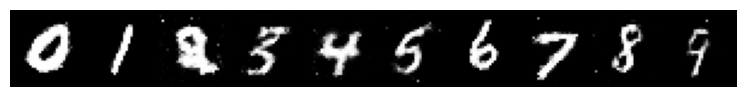

Epoch: 25


100%|██████████| 938/938 [03:20<00:00,  4.68it/s, d_loss=0.769, g_loss=2.5] 


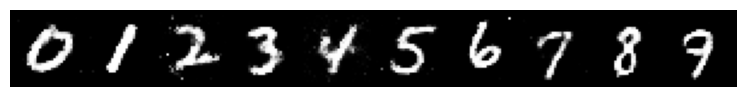

Epoch: 26


100%|██████████| 938/938 [03:21<00:00,  4.66it/s, d_loss=0.887, g_loss=1.74]


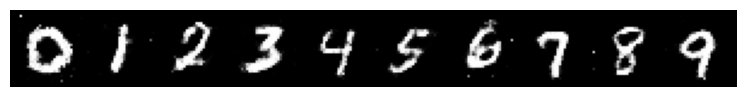

Epoch: 27


100%|██████████| 938/938 [03:48<00:00,  4.11it/s, d_loss=0.632, g_loss=2.32]


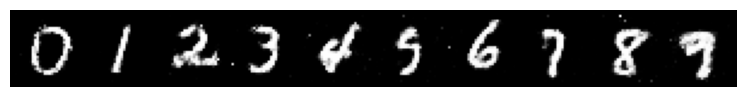

Epoch: 28


100%|██████████| 938/938 [03:44<00:00,  4.18it/s, d_loss=0.49, g_loss=2.61] 


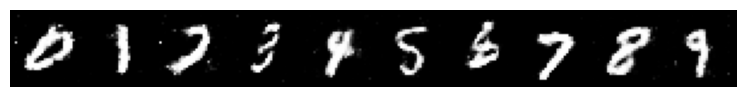

Epoch: 29


100%|██████████| 938/938 [03:23<00:00,  4.62it/s, d_loss=0.628, g_loss=2.76]


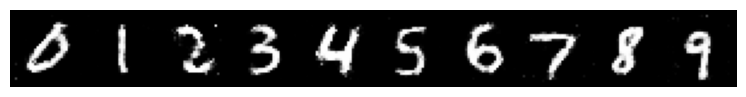

Save Model: 0.6727645363084124


In [14]:
EPOCH = 30
BATCH_SIZE = 64
NUM_WORKERS = 2
LR = 0.0001

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])
train_loader = DataLoader(
    MNIST(base_dir, train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss().to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=LR)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR)

# Start Training
for epoch in range(EPOCH):
  print(f"Epoch: {epoch}")

  gloss, dloss = train(generator, discriminator, train_loader, criterion,
                       g_optimizer, d_optimizer, epoch, device)

  validation(generator, epoch, device)

print(f"Save Model: {gloss}")
torch.save(generator.state_dict(), "last.pth")

(-0.5, 301.5, 301.5, -0.5)

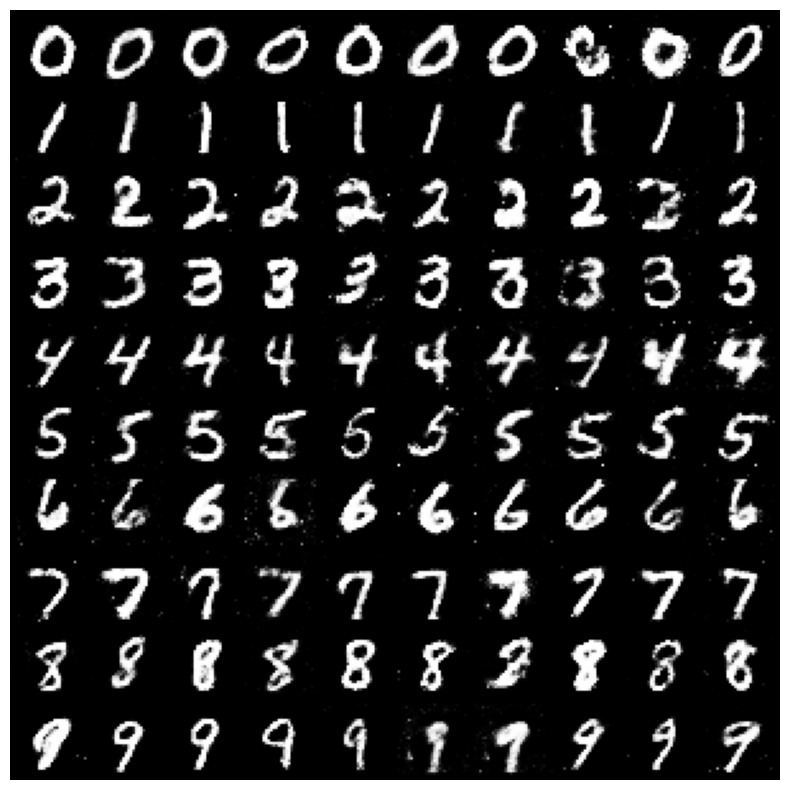

In [16]:
z = torch.randn(100, 100).to(device)
labels = (torch.arange(0, 100) // 10)

with torch.no_grad():
  images = generator(z, labels).unsqueeze(1)

grid = make_grid(images, nrow=10, normalize=True)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).cpu(), cmap='binary')
ax.axis('off')